In [68]:
import numpy as np
import torch 
torch._dynamo.config.suppress_errors = True
torch._dynamo.disable()
from tqdm import tqdm,trange    
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt
# from torch.utils.tensorboard import SummaryWriter

import os

print(os.getcwd())  

from flow_model_manipulator import Flow
import open3d as o3d

weights_dir = "../flow_training_weights"
opts_dir = "../flow_training_opts"
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(opts_dir, exist_ok=True)



/home/alinjar/manipulator/manipulator_mujoco/flow_matching


In [69]:


torch.set_float32_matmul_precision('high')

# writer = SummaryWriter("./logs")
test = 'manipulator'

In [70]:
BATCH_SIZE      = 500
LEARNING_RATE   = 1e-3
SEED            = 0
DEVICE          = 'cuda'      

In [71]:
torch.manual_seed(seed=SEED)
torch.cuda.manual_seed(seed=SEED)

In [72]:
class TrajDataset(Dataset):
    def __init__(self, theta_init_data, thetadot_init_data, target_pos_data, target_quat_data):
        
        # goal
        self.theta_init = theta_init_data
        self.thetadot_init = thetadot_init_data
        self.target_pos = target_pos_data
        self.target_quat = target_quat_data


        
    
    def __len__(self):
        return len(self.theta_init)    
            
    def __getitem__(self, idx):

        theta_init = self.theta_init[idx]
        thetadot_init = self.thetadot_init[idx]
        target_pos = self.target_pos[idx]
        target_quat = self.target_quat[idx]
                 
        return torch.tensor(theta_init).float(), torch.tensor(thetadot_init).float(), torch.tensor(target_pos).float(), \
            torch.tensor(target_quat).float()

In [73]:


# One step behind the current working directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

print(parent_dir)


/home/alinjar/manipulator/manipulator_mujoco


In [74]:


# Build relative paths from parent directory
data_dir = os.path.join(parent_dir, "custom_data_['target_2']_inference_False")
pcd_dir = os.path.join(parent_dir, "pcd_data")

print(data_dir)


/home/alinjar/manipulator/manipulator_mujoco/custom_data_['target_2']_inference_False


In [75]:
# Load the data

theta_init_data = np.loadtxt(os.path.join(data_dir, "theta.csv"), delimiter=",")
thetadot_init_data = np.loadtxt(os.path.join(data_dir, "thetadot.csv"), delimiter=",")
target_pos_data = np.loadtxt(os.path.join(data_dir, "target_positions.csv"), delimiter=",")
target_quat_data = np.loadtxt(os.path.join(data_dir, "target_quaternions.csv"), delimiter=",")



pcd_path = os.path.join(pcd_dir, "output_scene_without_robot_unpacked_rgb.pcd")
pcd = o3d.io.read_point_cloud(pcd_path)

# points = np.asarray(pcd.points)       # XYZ points
# colors = np.asarray(pcd.colors)       # RGB (if present)

# Convert Open3D point cloud to a NumPy array
pcd_np = np.asarray(pcd.points)

# Then convert to PyTorch tensor (and move to the correct device)

pcd_tensor = torch.tensor(pcd_np.T, dtype=torch.float32, device=DEVICE).unsqueeze(0)  # shape: [1, 3, length(pcd)]
pcd_tensor = pcd_tensor.permute(2, 1, 0)  # shape: [length(pcd), 3, 1]



print(pcd_tensor.shape)
# print(colors.shape)

print(theta_init_data.shape)
print(thetadot_init_data.shape)
print(target_pos_data.shape)
print(target_quat_data.shape)


torch.Size([307200, 3, 1])
(106, 6)
(106, 6)
(106, 3)
(106, 4)


In [76]:
theta_init_mean, theta_init_std = torch.tensor(theta_init_data.mean()).to(DEVICE), torch.tensor(theta_init_data.std()).to(DEVICE)
thetadot_init_mean, thetadot_init_std = torch.tensor(thetadot_init_data.mean()).to(DEVICE), torch.tensor(thetadot_init_data.std()).to(DEVICE)
target_pos_mean, target_pos_std = torch.tensor(target_pos_data.mean()).to(DEVICE), torch.tensor(target_pos_data.std()).to(DEVICE)
target_quat_mean, target_quat_std = torch.tensor(target_quat_data.mean()).to(DEVICE), torch.tensor(target_quat_data.std()).to(DEVICE)


In [77]:
dataset = TrajDataset(theta_init_data, thetadot_init_data, target_pos_data, target_quat_data)
print("len(dataset)", len(dataset))

train_size = int(0.9 * len(dataset))  
test_size = len(dataset) - train_size  

# Create a generator with a fixed seed
generator = torch.Generator().manual_seed(0)

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

out_chan = 512

flow = Flow(out_chan,theta_init_mean,theta_init_std, thetadot_init_mean, theta_init_std, target_pos_mean, target_pos_std,
            target_quat_mean, target_quat_std).cuda()

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(flow.parameters(), lr=LEARNING_RATE)

len(dataset) 106


In [78]:
flow.train()
c_flow = torch.compile(flow)


In [79]:

avg_losses = []
last_loss = torch.inf

NUM_EPOCH = 100
for epoch in range(NUM_EPOCH):
	losses = []
	
	for (theta_init,thetadot_init, target_pos, target_quat) in tqdm(train_loader):


		theta_init = theta_init.to(DEVICE)
		thetadot_init = thetadot_init.to(DEVICE)
		target_pos = target_pos.to(DEVICE)
		target_quat = target_quat.to(DEVICE)


		motion_data = torch.cat([theta_init, thetadot_init, target_pos, target_quat], dim=-1)  # or dim=1
		x_1 = motion_data

		x_0 = torch.randn_like(x_1)
		t = torch.rand(len(x_1), 1).to(device=DEVICE)
		x_t = (1 - t) * x_0 + t * x_1

		dx_t = x_1 - x_0
		loss = loss_fn(c_flow(x_t, motion_data, t, pcd_tensor), dx_t)
		losses.append(loss.item())

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()


	mean_loss = np.mean(losses)
	avg_losses.append(mean_loss)
	# scheduler.step()

	if epoch % 5 == 0:
		print(f"Epoch: {epoch + 1}, Train Loss: {mean_loss:.3f}")
	#writer.add_scalar('test_{}'.format(test), loss, epoch)

	if loss <= last_loss:
		# torch.save(flow.state_dict(), f"./weights/test_{test}_lowest.pt")
		# torch.save(optimizer.state_dict(), f"./opts/test_{test}_lowest.pt")
		torch.save(flow.state_dict(), f"{weights_dir}/test_{test}.pt")
		torch.save(optimizer.state_dict(), f"{opts_dir}/test_{test}.pt")
		last_loss = loss

100%|██████████| 1/1 [00:00<00:00, 35.85it/s]

Epoch: 1, Train Loss: 2.112



100%|██████████| 1/1 [00:00<00:00, 30.67it/s]


Epoch: 6, Train Loss: 1.418


100%|██████████| 1/1 [00:00<00:00, 32.70it/s]


Epoch: 11, Train Loss: 1.214


100%|██████████| 1/1 [00:00<00:00, 31.99it/s]


Epoch: 16, Train Loss: 1.100


100%|██████████| 1/1 [00:00<00:00, 31.77it/s]


Epoch: 21, Train Loss: 1.056


100%|██████████| 1/1 [00:00<00:00, 32.78it/s]


Epoch: 26, Train Loss: 1.138


100%|██████████| 1/1 [00:00<00:00, 26.90it/s]


Epoch: 31, Train Loss: 1.033


100%|██████████| 1/1 [00:00<00:00, 32.56it/s]


Epoch: 36, Train Loss: 1.068


100%|██████████| 1/1 [00:00<00:00, 32.45it/s]


Epoch: 41, Train Loss: 1.052


100%|██████████| 1/1 [00:00<00:00, 32.51it/s]


Epoch: 46, Train Loss: 0.935


100%|██████████| 1/1 [00:00<00:00, 30.80it/s]


Epoch: 51, Train Loss: 0.871


100%|██████████| 1/1 [00:00<00:00, 37.00it/s]


Epoch: 56, Train Loss: 0.754


100%|██████████| 1/1 [00:00<00:00, 33.59it/s]


Epoch: 61, Train Loss: 0.524


100%|██████████| 1/1 [00:00<00:00, 32.79it/s]


Epoch: 66, Train Loss: 0.380


100%|██████████| 1/1 [00:00<00:00, 35.51it/s]


Epoch: 71, Train Loss: 0.348


100%|██████████| 1/1 [00:00<00:00, 34.82it/s]


Epoch: 76, Train Loss: 0.333


100%|██████████| 1/1 [00:00<00:00, 35.93it/s]


Epoch: 81, Train Loss: 0.295


100%|██████████| 1/1 [00:00<00:00, 34.36it/s]


Epoch: 86, Train Loss: 0.230


100%|██████████| 1/1 [00:00<00:00, 30.53it/s]


Epoch: 91, Train Loss: 0.219


100%|██████████| 1/1 [00:00<00:00, 34.18it/s]


Epoch: 96, Train Loss: 0.169


100%|██████████| 1/1 [00:00<00:00, 31.94it/s]


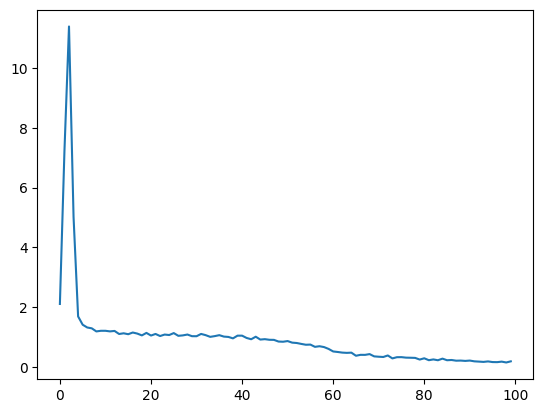

In [80]:
%matplotlib inline
plt.Figure()
plt.plot(avg_losses)
plt.show()

In [81]:
import contextlib
from io import StringIO

with contextlib.redirect_stdout(StringIO()):

    flow.load_state_dict(torch.load(f"../flow_training_weights/test_{test}.pt"))
# flow.load_state_dict(th.load(f"./weights/test_{test}_lowest.pt"))

    flow.eval()


/tmp/ipykernel_592313/3914206872.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  flow.load_state_dict(torch.load(f"../flow_training_weights/test_{test}.pt"))


In [82]:

# x_fin,y_fin,theta_init,theta_fin,gt_x,gt_y,index = next(iter(train_loader))

theta_init,thetadot_init, target_pos, target_quat = next(iter(train_loader))

# terrain_data = [theta_init, theta_fin, x_fin, y_fin, lam, th.hstack([p1,p2,p3,p4]), cov]

motion_data = torch.cat([theta_init, thetadot_init, target_pos, target_quat], dim=-1)

print(motion_data.shape)

torch.Size([95, 19])


In [ ]:


# x_1 = th.stack([gt_x,gt_y], dim=1)
# x_0 = th.randn_like(x_1)
# time_steps = th.linspace(0, 1.0, n_steps + 1, device=DEVICE).unsqueeze(1).unsqueeze(2)

x_1 =  motion_data.to(DEVICE)
#x_1 = x_1.unsqueeze(2)

# x_1 = x_1.unsqueeze(1).repeat(1, 95, 1)

x_0 = torch.randn_like(x_1).to(DEVICE)

pcd_tensor = pcd_tensor.to(DEVICE)

x = x_0.clone().to(DEVICE)




In [ ]:
print(x.shape)
print(motion_data.shape)

torch.Size([95, 19])
torch.Size([95, 19])
torch.Size([9, 1])


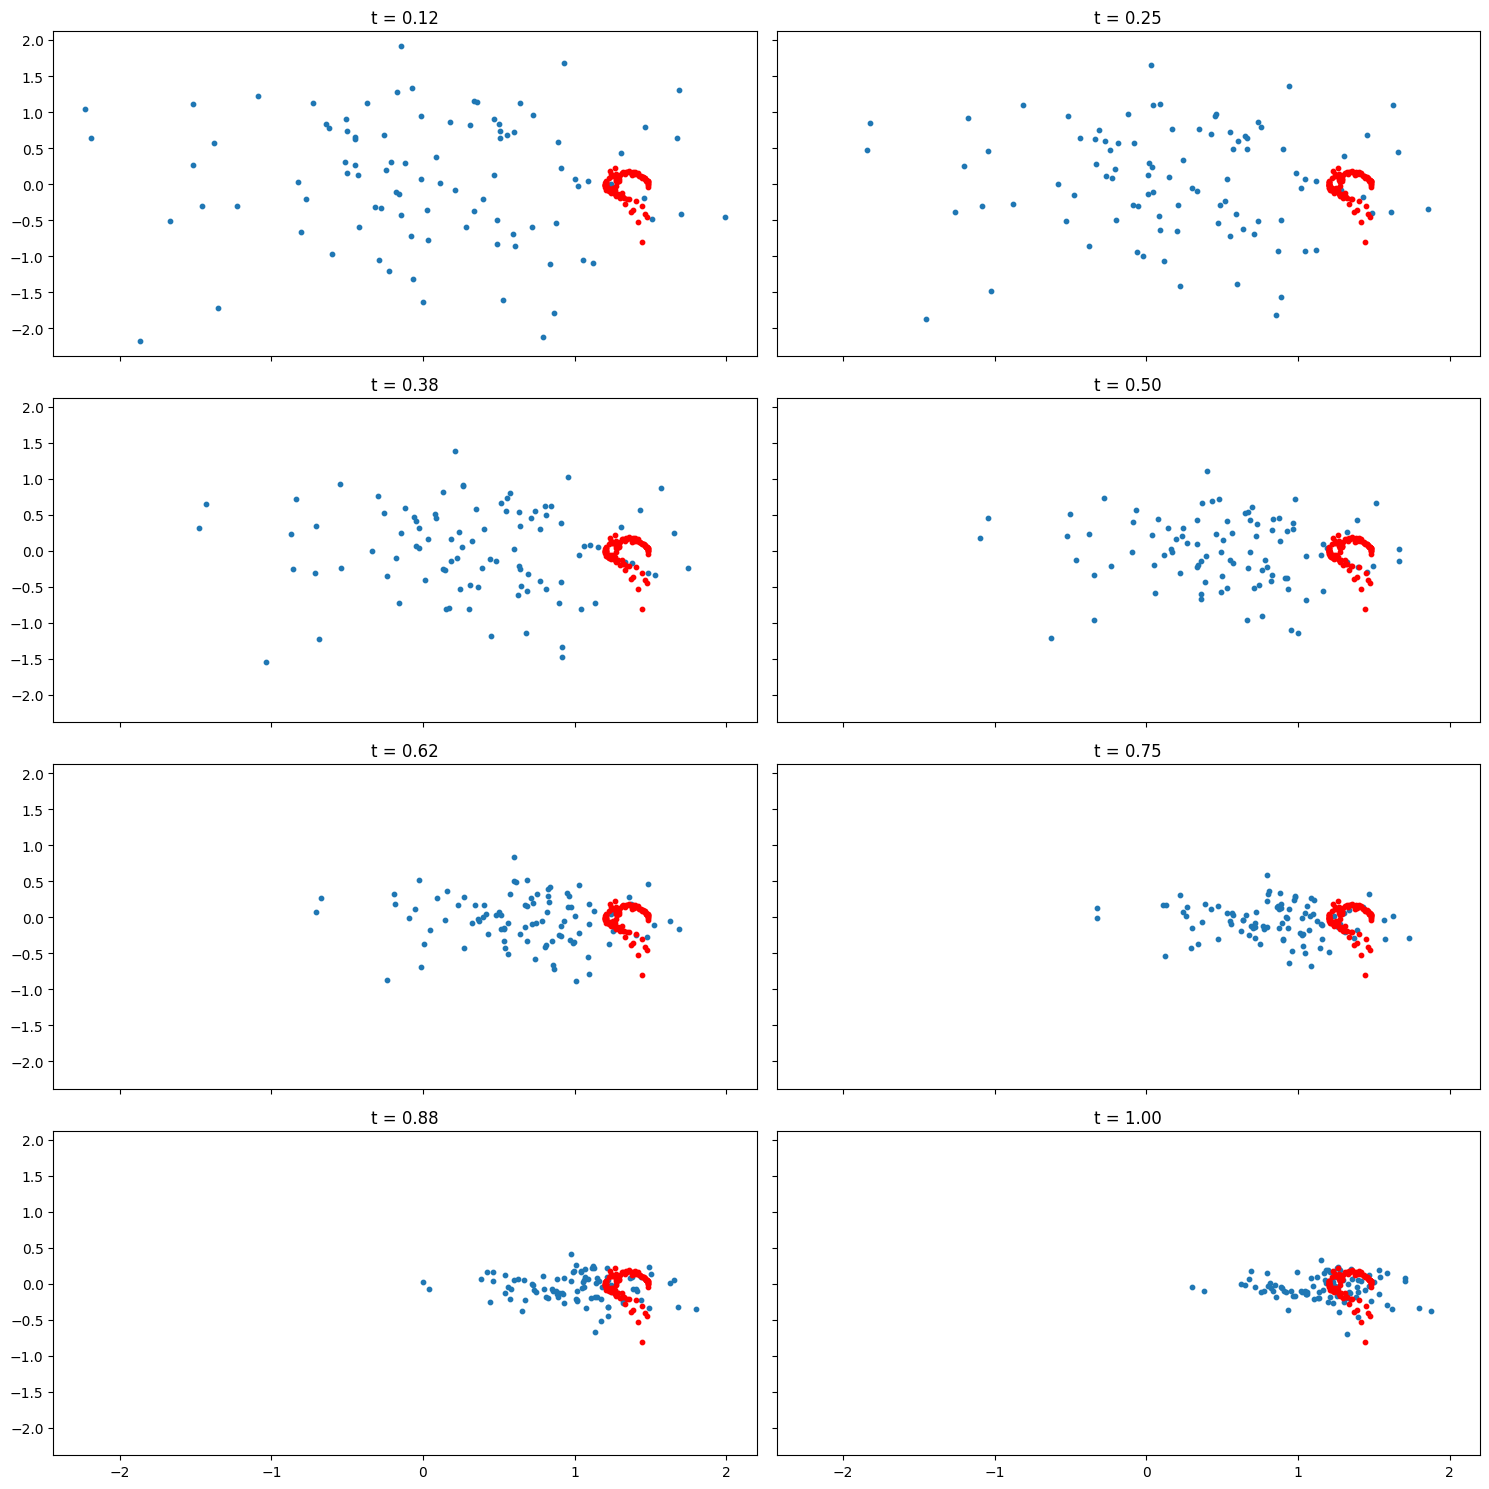

In [ ]:
n_steps = 8 

time_steps = torch.linspace(0, 1.0, n_steps + 1).unsqueeze(1)
time_steps = time_steps.to(DEVICE)

n_row = 4
n_col = int(n_steps / n_row)
rows, cols = n_row, n_col
fig, axes = plt.subplots(rows, cols, figsize=(15, 15), sharex=True, sharey=True)

for i in range(n_steps):
	with torch.inference_mode():
		t0 = time_steps[i].view(1, 1).expand(x_0.shape[0], 1)
		t1 = time_steps[i+1].view(1, 1).expand(x_0.shape[0], 1)

		x = flow.step(x, motion_data, t0, t1, pcd_tensor)
		x_ = x.detach().cpu().numpy()
		x1_ = x_1.detach().cpu().numpy()

		row, col = divmod(i, cols)
		ax = axes[row, col]
		ax.scatter(x_[:, 0], x_[:, 6], s=10)
		ax.scatter(x1_[:, 0], x1_[:, 6], color='red', s=10)
		ax.set_title(f't = {time_steps[i+1].item():.2f}')
plt.tight_layout()
plt.show()		


In [86]:
print(x_.shape)
print(x1_.shape)

(95, 19)
(95, 19)
